# To Grant or Not to Grant: Deciding on Compensation Benefits 

### Machine Learning Group Project 2024/2025 - Group 52


__Members:__
- Diogo Rodrigues _(20240512@novaims.unl.pt)_
- Alexandre Gonçalves _(20240738@novaims.unl.pt)_
- Pedro Costa _(20222121@novaims.unl.pt)_
- Santiago Taylor _(20240542@novaims.unl.pt)_
- Lena Hermann _(20241446@novaims.unl.pt)_

## Introduction
- __Motivation__: x
- __Dataset__: The dataset represents claims from the start of 2020 till the end of 2022 (training data) and from January 2023 onward (test data). A detailed description of the columns of the datasets can be found below.
- __Task and Goal__: The purpose of this notebook is to create and evaluate several classification models for accurately predicting the WCB’s final decision on what type of injury should be given to a claim.

| **ATTRIBUTE**                        | **DESCRIPTION**                                                                                                         |
|--------------------------------------|-------------------------------------------------------------------------------------------------------------------------|
| Accident Date                        | Injury date of the claim.                                                                                               |
| Age at Injury                        | Age of injured worker when the injury occurred.                                                                         |
| Alternative Dispute Resolution       | Adjudication processes external to the Board.                                                                           |
| Assembly Date                        | The date the claim was first assembled.                                                                                 |
| Attorney/Representative              | Is the claim being represented by an Attorney?                                                                          |
| Average Weekly Wage                  | The wage used to calculate workers’ compensation, disability, or Paid Leave wage replacement benefits.                  |
| Birth Year                           | The reported year of birth of the injured worker.                                                                       |
| C-2 Date                             | Date of receipt of the Employer's Report of Work-Related Injury/Illness or equivalent (formerly Form C-2).              |
| C-3 Date                             | Date Form C-3 (Employee Claim Form) was received.                                                                       |
| Carrier Name                         | Name of primary insurance provider responsible for providing workers’ compensation coverage to the injured worker's employer. |
| Carrier Type                         | Type of primary insurance provider responsible for providing workers’ compensation coverage.                            |
| Claim Identifier                     | Unique identifier for each claim, assigned by WCB.                                                                      |
| County of Injury                     | Name of the New York County where the injury occurred.                                                                  |
| COVID-19 Indicator                   | Indication that the claim may be associated with COVID-19.                                                              |
| District Name                        | Name of the WCB district office that oversees claims for that region or area of the state.                              |
| First Hearing Date                   | Date the first hearing was held on a claim at a WCB hearing location. A blank date means the claim has not yet had a hearing held. |
| Gender                               | The reported gender of the injured worker.                                                                              |
| IME-4 Count                          | Number of IME-4 forms received per claim. The IME-4 form is the “Independent Examiner’s Report of Independent Medical Examination” form. |
| Industry Code                        | NAICS code and descriptions are available at https://www.naics.com/search-naics-codes-by-industry/.                     |
| Industry Code Description            | 2-digit NAICS industry code description used to classify businesses according to their economic activity.               |
| Medical Fee Region                   | Approximate region where the injured worker would receive medical service.                                               |
| OIICS Nature of Injury Description   | The OIICS nature of injury codes & descriptions are available at https://www.bls.gov/iif/oiics_manual_2007.pdf.         |
| WCIO Cause of Injury Code            | The WCIO cause of injury codes & descriptions are available at https://www.wcio.org/Active%20PNC/WCIO_Cause_Table.pdf.  |
| WCIO Cause of Injury Description     | See description of field above.                                                                                         |
| WCIO Nature of Injury Code           | The WCIO nature of injury are available at https://www.wcio.org/Active%20PNC/WCIO_Nature_Table.pdf.                     |
| WCIO Nature of Injury Description    | See description of field above.                                                                                         |
| WCIO Part Of Body Code               | The WCIO part of body codes & descriptions are available at https://www.wcio.org/Active%20PNC/WCIO_Part_Table.pdf.      |
| WCIO Part Of Body Description        | See description of field above.                                                                                         |
| Zip Code                             | The reported ZIP code of the injured worker’s home address.                                                             |
| Agreement Reached                    | Binary variable: Yes if there is an agreement without the involvement of the WCB -> unknown at the start of a claim.    |
| WCB Decision                         | Multiclass variable: Decision of the WCB relative to the claim: “Accident” means that claim refers to workplace accident, “Occupational Disease” means illness from the workplace. -> requires WCB deliberation so it is unknown at start of claim. |
| Claim Injury Type                    | Main target variable: Deliberation of the WCB relative to benefits awarded to the claim. Numbering indicates severity.   |


## Table of Content
<a id='top'></a>
[1. Set-Up and Data Loading](#dataload) <br>
[2. Data Understanding and Exploration](#dataunderstand) <br>
[3. Data Cleaning and Pre-processing](#dataclean) <br>
[4. Feature Selection](#features) <br>
[5. Modeling and Evaluation](#modeling) <br>

## 1. Set-Up and Data Loading <a id='dataload'></a>
[to the top](#top)

### 1.1 Import the needed libraries

In [1]:
import numpy as np #to efficiently compute functions
import pandas as pd #to work with data frames
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import zipfile #to open zipfile
import os

# data partition
from sklearn.model_selection import train_test_split

#filter methods
# spearman 
# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE


# embedded methods
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings('ignore')

### 1.2 Read the data and first overview

In [30]:
train_zip_path = 'train_data.csv.zip'
test_zip_path = 'test_data.csv.zip'

# open csv file from zip
def read_zipped_csv(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as z:
        csv_filename = z.namelist()[0]
        
        with z.open(csv_filename) as f:
            return pd.read_csv(f)

train_df = read_zipped_csv(train_zip_path)
test_df = read_zipped_csv(test_zip_path)

print("Train Data:")
print(train_df.head())
print("\nTest Data:")
print(test_df.head())

Train Data:
  Accident Date  Age at Injury Alternative Dispute Resolution Assembly Date  \
0    2019-12-30           31.0                              N    2020-01-01   
1    2019-08-30           46.0                              N    2020-01-01   
2    2019-12-06           40.0                              N    2020-01-01   
3           NaN            NaN                            NaN    2020-01-01   
4    2019-12-30           61.0                              N    2020-01-01   

  Attorney/Representative  Average Weekly Wage  Birth Year    C-2 Date  \
0                       N                 0.00      1988.0  2019-12-31   
1                       Y              1745.93      1973.0  2020-01-01   
2                       N              1434.80      1979.0  2020-01-01   
3                     NaN                  NaN         NaN         NaN   
4                       N                  NaN      1958.0  2019-12-31   

     C-3 Date                  Carrier Name  ... WCIO Cause of Injur

In [3]:
train_df.head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,...,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,...,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,...,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,...,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0


## 2. Data Understanding and Exploration <a id='dataunderstand'></a>
[to the top](#top)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       570337 non-null  object 
 1   Age at Injury                       574026 non-null  float64
 2   Alternative Dispute Resolution      574026 non-null  object 
 3   Assembly Date                       593471 non-null  object 
 4   Attorney/Representative             574026 non-null  object 
 5   Average Weekly Wage                 545375 non-null  float64
 6   Birth Year                          544948 non-null  float64
 7   C-2 Date                            559466 non-null  object 
 8   C-3 Date                            187245 non-null  object 
 9   Carrier Name                        574026 non-null  object 
 10  Carrier Type                        574026 non-null  object 
 11  Claim Identifier          

In [5]:
# Have a first look at the numerical variables and their distirbutions
train_df.describe()

,Age at Injury,Average Weekly Wage,Birth Year,Claim Identifier,IME-4 Count,Industry Code,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Agreement Reached,Number of Dependents
count,574026.000000,5.453750e+05,544948.000000,5.934710e+05,132803.000000,564068.000000,0.0,558386.000000,558369.000000,556944.000000,574026.000000,574026.000000
mean,42.114270,4.910883e+02,1886.767604,2.366760e+07,3.207337,58.645305,NaN,54.381143,41.013839,39.738146,0.046665,3.006559
std,14.256432,6.092918e+03,414.644423,1.079271e+08,2.832303,19.644175,NaN,25.874281,22.207521,22.365940,0.210921,2.000801
min,0.000000,0.000000e+00,0.000000,5.393066e+06,1.000000,11.000000,NaN,1.000000,1.000000,-9.000000,0.000000,0.000000
25%,31.000000,0.000000e+00,1965.000000,5.593414e+06,1.000000,45.000000,NaN,31.000000,16.000000,33.000000,0.000000,1.000000
50%,42.000000,0.000000e+00,1977.000000,5.791212e+06,2.000000,61.000000,NaN,56.000000,49.000000,38.000000,0.000000,3.000000
75%,54.000000,8.410000e+02,1989.000000,5.991000e+06,4.000000,71.000000,NaN,75.000000,52.000000,53.000000,0.000000,5.000000
max,117.000000,2.828079e+06,2018.000000,9.998917e+08,73.000000,92.000000,NaN,99.000000,91.000000,99.000000,1.000000,6.000000


In [6]:
# Have a first look at the categorical variables and their distirbutions
train_df.describe(include='O')

,Accident Date,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,...,District Name,First Hearing Date,Gender,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Description,WCIO Nature of Injury Description,WCIO Part Of Body Description,Zip Code,WCB Decision
count,570337,574026,593471,574026,559466,187245,574026,574026,574026,574026,...,574026,150798,574026,564068,574026,558386,558369,556944,545389,574026
unique,5539,3,1096,2,2475,1648,2046,8,8,63,...,8,1094,4,20,5,74,56,54,10060,1
top,2020-03-01,N,2020-03-06,N,2021-05-11,2021-04-21,STATE INSURANCE FUND,1A. PRIVATE,2. NON-COMP,SUFFOLK,...,NYC,2022-04-15,M,HEALTH CARE AND SOCIAL ASSISTANCE,IV,LIFTING,STRAIN OR TEAR,LOWER BACK AREA,11236,Not Work Related
freq,1245,571412,1422,392291,1847,350,111144,285368,291078,60430,...,270779,440,335218,114339,265981,46610,153373,51862,3302,574026


__Target Variable__

We just have a look at the distribution of the target variable 'Claim Injury Type'. To check how our dataset is balanced.

In [7]:
train_df['Claim Injury Type'].value_counts()

Claim Injury Type
2. NON-COMP        291078
4. TEMPORARY       148507
3. MED ONLY         68906
5. PPD SCH LOSS     48280
1. CANCELLED        12477
6. PPD NSL           4211
8. DEATH              470
7. PTD                 97
Name: count, dtype: int64

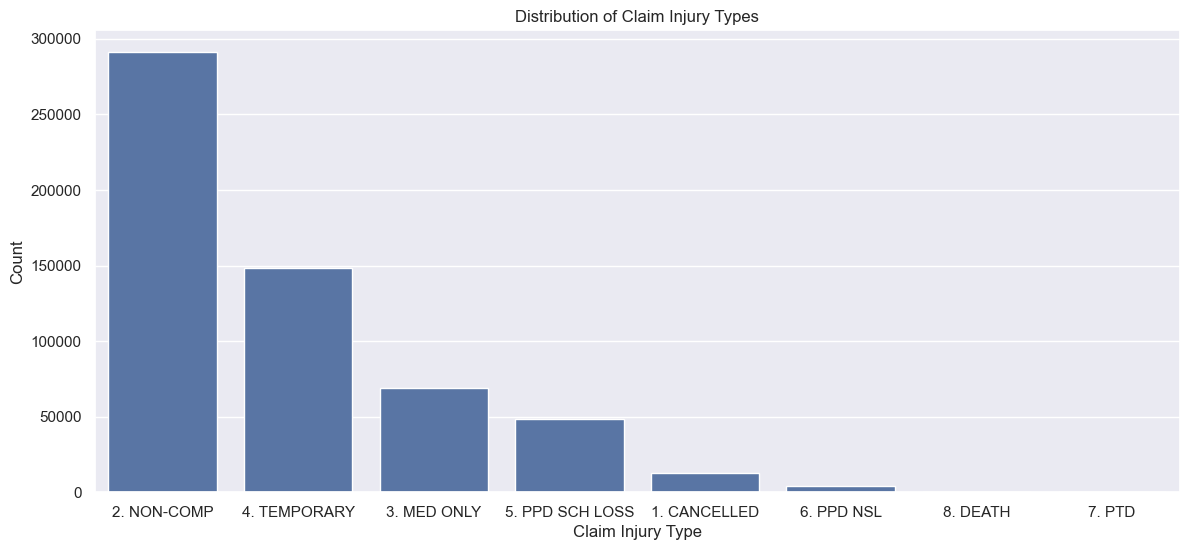

In [8]:
# Plot distribution of target values
target_values = train_df['Claim Injury Type'].value_counts()

df_target_counts = target_values.reset_index()
df_target_counts.columns = ['Claim Injury Type', 'Count']

plt.figure(figsize=(14, 6))
sns.barplot(x='Claim Injury Type', y='Count', data=df_target_counts)
#plt.xticks(rotation=45)
plt.title('Distribution of Claim Injury Types')
plt.show()

__Metric and Non Metric Variables__

In [54]:
metric_features = ["Age at Injury","Average Weekly Wage","Birth Year","Claim Identifier","IME-4 Count","Agreement Reached","Number of Dependents"]
non_metric_features = train_df.columns.drop(metric_features).to_list()

__Histograms__

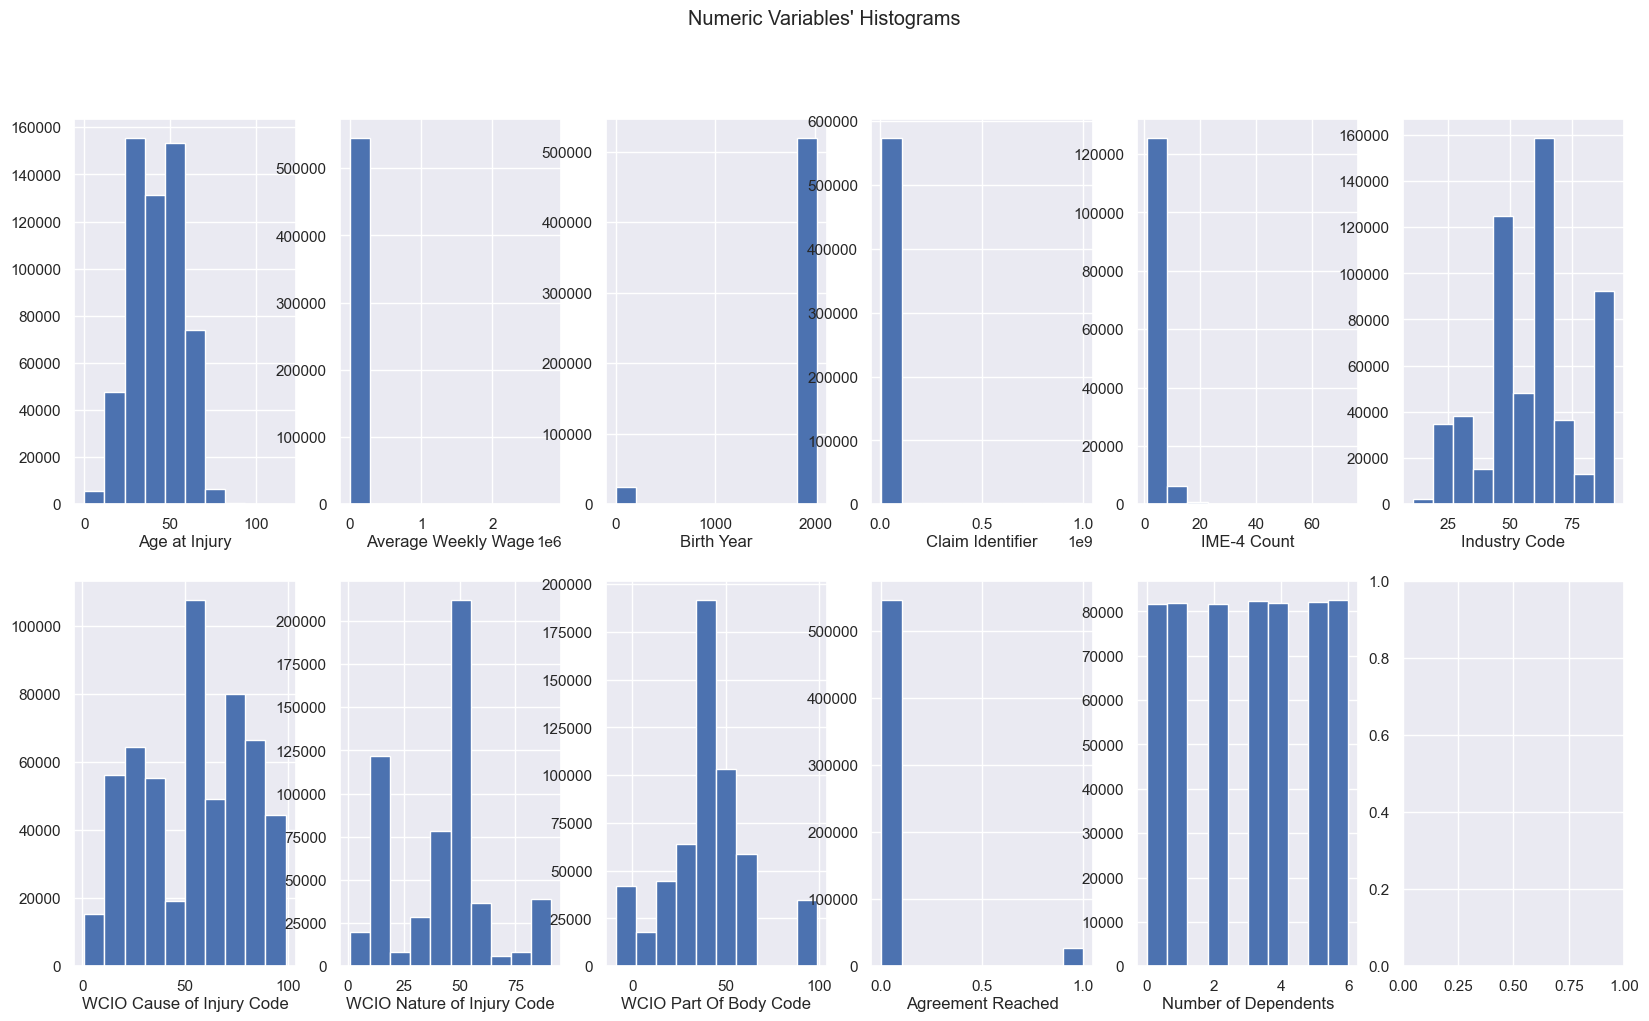

In [10]:
# Plot ALL Numeric Variables' Histograms in one figure

sns.set() ## Reset to darkgrid

sp_rows = 2
sp_cols = 6


# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(sp_rows, 
                         sp_cols, 
                         figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.hist(train_df[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title)

if not os.path.exists(os.path.join('..', 'figures', 'eda')):
    # if the exp_analysis directory is not present then create it first
    os.makedirs(os.path.join('..', 'figures', 'eda'))
    
plt.savefig(os.path.join('..', 'figures', 'eda', 'numeric_variables_histograms.png'), dpi=200)

plt.show()

_"Explore data visually and extract relevant insights. Explain your rationale and
findings. Do not forget to analyse multivariate relationships."_

## 3. Data Cleaning and Pre-processing <a id='dataclean'></a>
[to the top](#top)

- _"Are there any missing values? Take action to handle them._
- _Check the dataset for outliers and pre-process them. Justify your decisions._
- _Deal with categorical variables._
- _Review current features and create extra features if needed. Explain your steps._
- _Perform data scaling. Explain the reasoning behind your choices."_

### 3.1 Missing Values

In [62]:
# Calculation of the number and percentage of missing values per column
missing_values = train_df.isna().sum()
missing_percentage = round((train_df.isna().sum() / len(train_df)) * 100,2)

missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

print(missing_data)

                                   Missing Values  Percentage
Accident Date                                   0        0.00
Age at Injury                                   0        0.00
Alternative Dispute Resolution                  0        0.00
Assembly Date                                   0        0.00
Attorney/Representative                         0        0.00
Average Weekly Wage                         28651        4.99
Birth Year                                      0        0.00
C-2 Date                                    14560        2.54
C-3 Date                                   386781       67.38
Carrier Name                                    0        0.00
Carrier Type                                    0        0.00
Claim Identifier                                0        0.00
Claim Injury Type                               0        0.00
County of Injury                                0        0.00
COVID-19 Indicator                              0        0.00
District

The first look at the missing values reveals four insights:
1. There exist __only two__ variables __without missing values__ (Assembly Date and Claim Identifier)
2. There exists __one__ variable with __only missing values__ (OIICS Nature of Injury Description). This variable will be dropped directly.
3. There exist __three__ variables with missing values ranging from __68% - 78%__, which might be dropped.
4. Several variabes show the __same amount of missing values__ (3.28% and 5.91%)

In [32]:
train_df = train_df.drop(columns='OIICS Nature of Injury Description')
#drop rows where the target variable is missing
train_df=train_df.dropna(subset=['Claim Injury Type'])

In [60]:
# rows without missing values
rows_without_missing_values = train_df.dropna()
num_rows_without_missing_values = len(rows_without_missing_values)

print(f"Number of rows without missing values: {num_rows_without_missing_values}")

Number of rows without missing values: 93417


__Relationship between Weekly Wage and Attorney__

In [61]:
# Group by 'Attorney/Representative' and calculate the mean of 'Average Weekly Wage'
attorney_wage_comparison = train_df.groupby('Attorney/Representative')['Average Weekly Wage'].mean()

# Display the result
print(attorney_wage_comparison)

Attorney/Representative
N     247.430211
Y    1016.801511
Name: Average Weekly Wage, dtype: float64


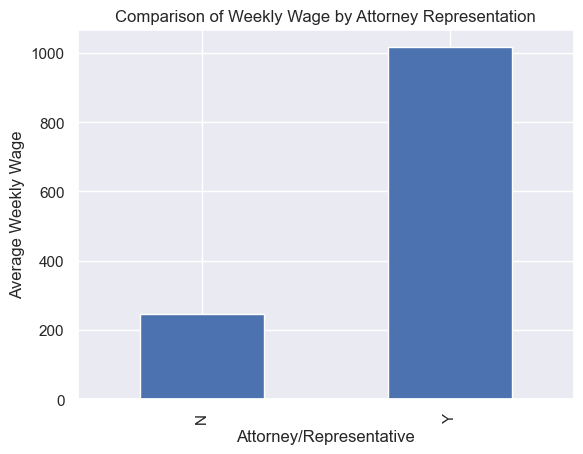

In [15]:
attorney_wage_comparison.plot(kind='bar')
plt.ylabel('Average Weekly Wage')
plt.title('Comparison of Weekly Wage by Attorney Representation')
plt.show()

In [59]:
nunique_values = train_df.apply(lambda col: col.nunique())

unique_values = train_df.apply(lambda col: col.unique())

unique_data = pd.DataFrame({'Nº unique Values': nunique_values, 'Unique Values': unique_values})
unique_data

,Nº unique Values,Unique Values
Accident Date,5540,"[2019-12-30, 2019-08-30, 2019-12-06, 2019-12-2..."
Age at Injury,108,"[31.0, 46.0, 40.0, 61.0, 67.0, 48.0, 33.0, 55...."
Alternative Dispute Resolution,3,"[N, Y, U]"
Assembly Date,897,"[2020-01-01, 2020-01-02, 2020-01-03, 2020-01-0..."
Attorney/Representative,2,"[N, Y]"
Average Weekly Wage,120024,"[0.0, 1745.93, 1434.8, nan, 225.0, 512.95, 171..."
Birth Year,107,"[1988.0, 1973.0, 1979.0, 1958.0, 1952.0, 1971...."
C-2 Date,2475,"[2019-12-31, 2020-01-01, 2019-07-31, 2020-01-0..."
C-3 Date,1648,"[nan, 2020-01-14, 2020-03-04, 2020-01-07, 2020..."
Carrier Name,2046,"[NEW HAMPSHIRE INSURANCE CO, ZURICH AMERICAN I..."


In [17]:
print(train_df["Alternative Dispute Resolution"].value_counts())
print((train_df['Carrier Name'] == "U").sum())

Alternative Dispute Resolution
N    571412
Y      2609
U         5
Name: count, dtype: int64
0


In [55]:
mean=train_df[metric_features].mean()
print(mean)

median=train_df[metric_features].median()
print(median)


Age at Injury           4.211427e+01
Average Weekly Wage     4.910883e+02
Birth Year              1.891338e+03
Claim Identifier        5.778956e+06
IME-4 Count             3.207337e+00
Agreement Reached       4.666513e-02
Number of Dependents    3.006559e+00
dtype: float64
Age at Injury                42.0
Average Weekly Wage           0.0
Birth Year                 1977.0
Claim Identifier        5778282.5
IME-4 Count                   2.0
Agreement Reached             0.0
Number of Dependents          3.0
dtype: float64


In [56]:
mode=train_df[non_metric_features].mode().loc[0]
print(mode)

Accident Date                                                        U
Alternative Dispute Resolution                                       N
Assembly Date                                               2020-03-06
Attorney/Representative                                              N
C-2 Date                                                    2021-05-11
C-3 Date                                                    2021-04-21
Carrier Name                                      STATE INSURANCE FUND
Carrier Type                                               1A. PRIVATE
Claim Injury Type                                          2. NON-COMP
County of Injury                                               SUFFOLK
COVID-19 Indicator                                                   N
District Name                                                      NYC
First Hearing Date                                                   U
Gender                                                               M
Indust

In [58]:
#Accident Date
train_df["Accident Date"].fillna('U', inplace=True)

#Average Weekly Wage ????
#trin_df['Accident Date'].fillna(????)

#Birth Year
train_df["Birth Year"].fillna(median["Birth Year"],inplace=True)

#C2-DATE AND C3-DATE ????

#First Hearing Date
train_df["First Hearing Date"].fillna('U',inplace=True)

#IME-4 Count     with 0's, U, median or mean
#train_df["IME-4 Count"].fillna()

#Industry Code
train_df["Industry Code"].fillna(mode['Industry Code'],inplace=True)

#Industry Code Description
train_df["Industry Code Description"].fillna(mode['Industry Code Description'],inplace=True)

#WCIO Cause of Injury Code
train_df["WCIO Cause of Injury Code"].fillna(mode['WCIO Cause of Injury Code'],inplace=True)

#WCIO Cause of Injury Description
train_df["WCIO Cause of Injury Description"].fillna(mode['WCIO Cause of Injury Description'],inplace=True)

#WCIO Nature of Injury Code
train_df["WCIO Nature of Injury Code"].fillna(mode['WCIO Nature of Injury Code'],inplace=True)

#WCIO Nature of Injury Description
train_df["WCIO Nature of Injury Description"].fillna(mode['WCIO Nature of Injury Description'],inplace=True)

#WCIO Part Of Body Code 
train_df["WCIO Part Of Body Code"].fillna(mode['WCIO Part Of Body Code'],inplace=True)

#WCIO Part of Body Description
train_df["WCIO Part Of Body Description"].fillna(mode['WCIO Part Of Body Description'],inplace=True)

#Zip Code
train_df["Zip Code"].fillna(mode['Zip Code'],inplace=True)

#???

__Missing__

1. Attorney
2. Average Weekly Wage
3. C2-C3 Date


### 3.2 Outliers

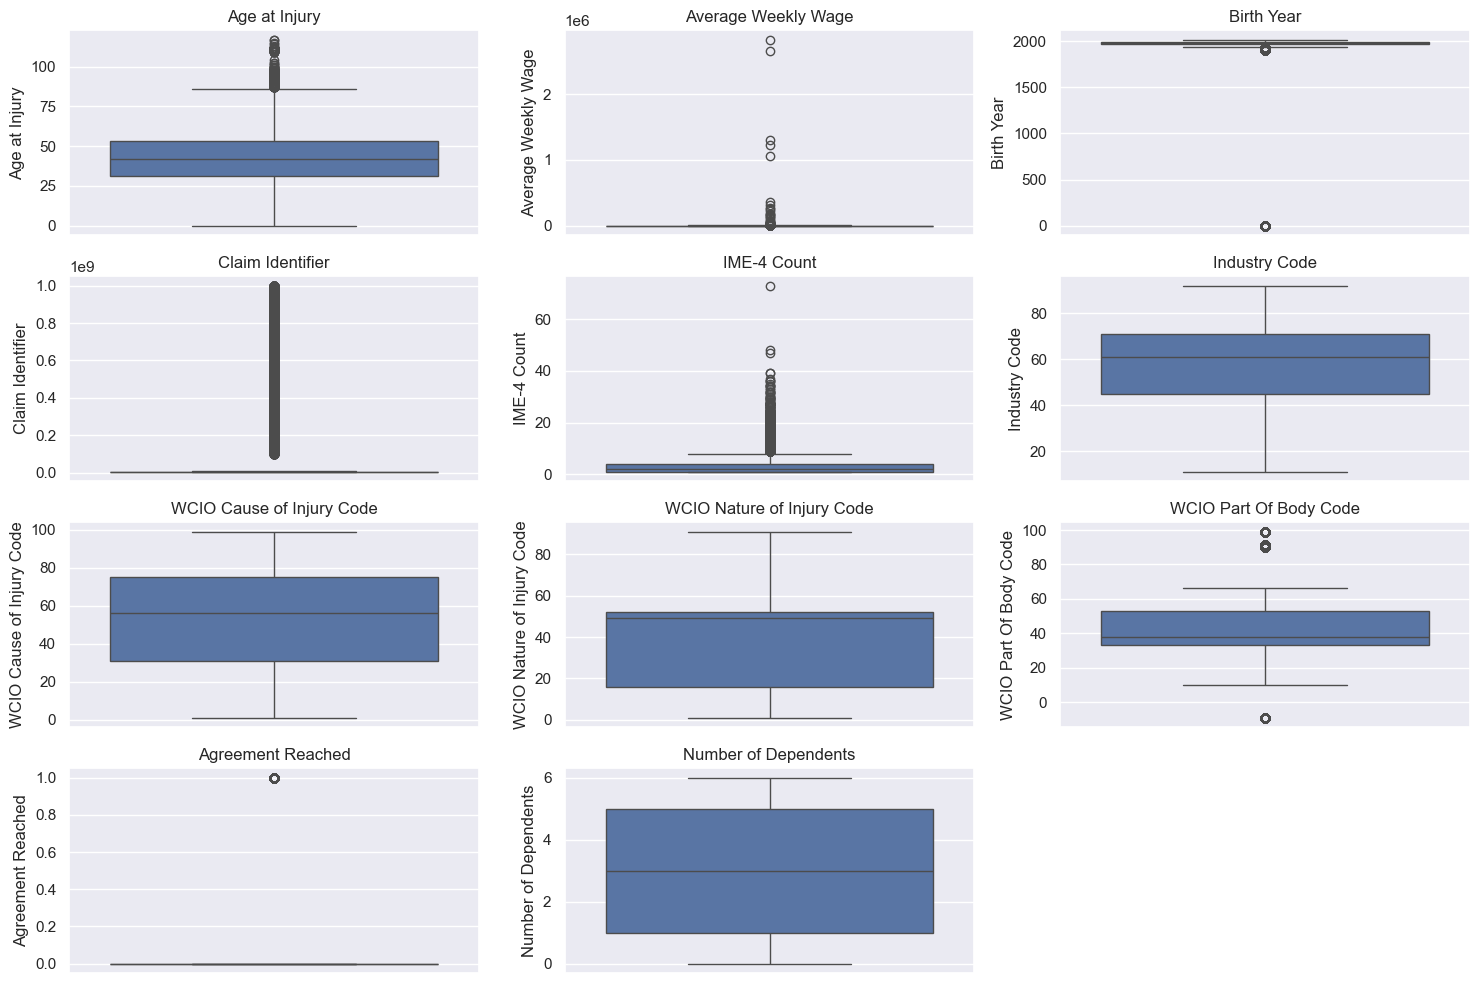

In [20]:
plt.figure(figsize=(15, 10))


for i, col in enumerate(metric_features):
    plt.subplot(len(metric_features) // 3 + 1, 3, i + 1)
    sns.boxplot(y=train_df[col])
    plt.title(col)


plt.tight_layout()
plt.show()

__Observations__

1. Check values above 100 in Age at Injury
2. In wages, are they very rich or just an error ???
3. Remove the outliers in Birth Year
4. Treat Claim Identifier as a Categorical Value maybe
5. Check the high values in IME-4...
6. Agreement Reached is binary (0 or 1)
7. Check the outliers in WCIO Part of Body Code 

In [21]:
#Treating Treat Claim as a Categorical Value
#Removed "Claim Identifier" in metric-features

metric_features = ["Age at Injury","Average Weekly Wage","Birth Year","IME-4 Count","Industry Code","WCIO Cause of Injury Code","WCIO Nature of Injury Code","WCIO Part Of Body Code","Agreement Reached","Number of Dependents"]
non_metric_features = train_df.columns.drop(metric_features,).to_list()

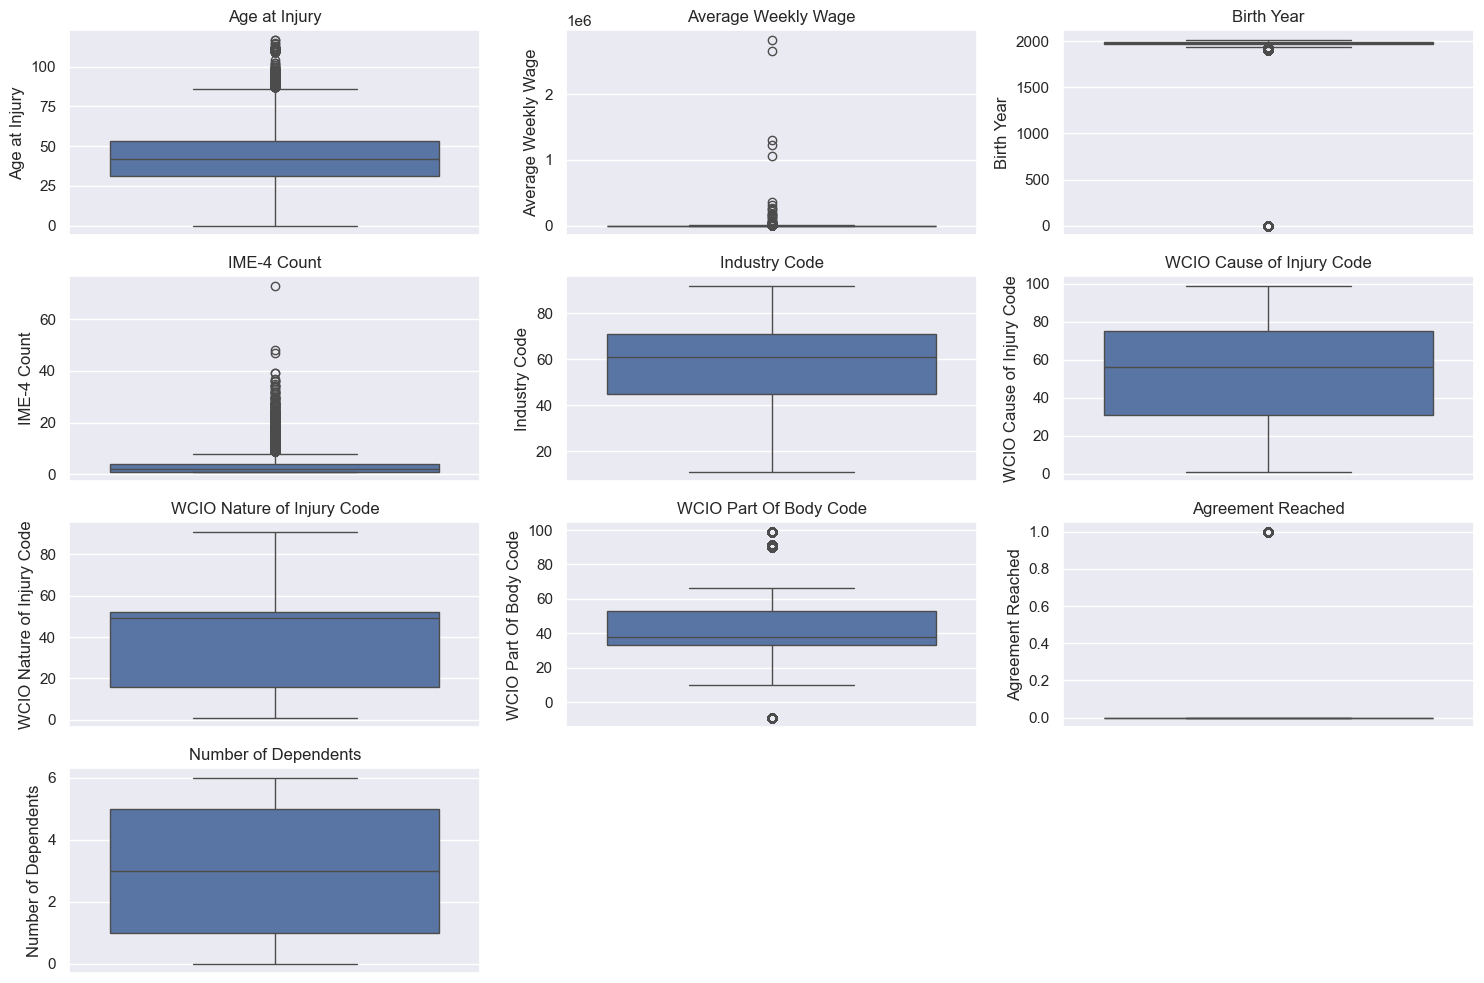

In [22]:
plt.figure(figsize=(15, 10))

# Boxplot
for i, col in enumerate(metric_features):
    plt.subplot(len(metric_features) // 3 + 1, 3, i + 1)
    sns.boxplot(y=train_df[col])
    plt.title(col)

# Ajustar layout
plt.tight_layout()
plt.show()

### 3.3 Categorical Values

### 3.4 Feature Extraction

In [23]:
threshold = 0.5  # 50% 

max_missing = int(threshold * train_df.shape[1])

print(max_missing)

mask = train_df.isnull().sum(axis=1) > max_missing

excess_rows = train_df[mask]

print("Rows with more than 50% missing values")
print(excess_rows)

16
Rows with more than 50% missing values
       Accident Date  Age at Injury Alternative Dispute Resolution  \
3                  U           42.0                              U   
33                 U           42.0                              U   
37                 U           42.0                              U   
42                 U           42.0                              U   
51                 U           42.0                              U   
...              ...            ...                            ...   
593465             U           42.0                              U   
593466             U           42.0                              U   
593468             U           42.0                              U   
593469             U           42.0                              U   
593470             U           42.0                              U   

       Assembly Date Attorney/Representative  Average Weekly Wage  Birth Year  \
3         2020-01-01                

Should we remove this __19445__ rows?

### 3.5 Data Scaling

## 4. Feature Selection <a id='features'></a>
[to the top](#top)

_"Define and implement an unambiguous strategy for feature selection. Use methods discussed in the course. Present and justify your final selection."_

## 5. Modeling and Evaluation <a id='modeling'></a>
[to the top](#top)

- _"Identify the type of the problem and select the relevant algorithms._
- _Use cross-validation to assess performance. Which metrics did you use and why?_
- _Train at least 1 model using the train dataset and obtain predictions for the test dataset."_

In [24]:
# test

test test